In [15]:
import os

import numpy as np
import astropy.units as u
from astropy.table import Table
from sherpa.models import NormGauss1D, Scale1D
from sherpa.astro.models import Lorentz1D
import matplotlib.pyplot as plt

from makermf import RMF, caldb2sherpa

%matplotlib inline

## Setup up Sherpa model and CALBD file readers


In [5]:
import ciao_contrib.runtool as rt
# MEG is 1100
rt.set_pfiles(os.path.abspath(os.curdir))

rt.ardlib.AXAF_HETG_1100_LSF_FILE = 'test_lsf.fits'
rt.ardlib.write_params()

In [6]:
# Do all those tests at one energy
myenergy = 0.99985 * u.keV
mywave = myenergy.to(u.Angstrom, equivalencies=u.spectral())

## Understanding the LSFPARM files in the CALDB

File format spec: https://space.mit.edu/cxc/docs/ICD_mkgrmf_ard.ps.gz

According to the ICD the format of the PARAM entries is: 
- Gauss: Amplitude, sigma in Angstroem, position absolute numbers in Angstroem
- Lorentz: Amplitude, width in Angstroem, position absolute numbers in Angstroem

However, version 0.2.1 of the spec has several typographical errors and inconsistencies, so some experiementation is needed to reverse engeneer the actual specification used by CIAO. Below, I do just that, so that I can update the ICD to match reality and save the next person who needs it the work to do it again.

### Functional forms for Gauss and Lorentz functions
Unfortunately, there are many different possible definitions for a Gauss and a Lorzentz function (e.g. using $\sigma$ or $FWHM$ as a parameters? Normalize the area under the curve or the value at the maximum?). So, we first have to reconcile the definitions used in the ICD for the CALDB files and in the fitting program that we are going to use.

#### Gauss
The ICD gives the following functional form 
$$
G(x) = \frac{1.}{2\pi \sigma} e^\frac{-(r-r_0)^2}{(2\sigma^2)}
$$
This differs from the normal definition of a Gaussian by a missing $\sqrt{}$ in the normalization factor. The following, more usual, definition integrates to 1.
$$
G(x) = \frac{1.}{\sqrt{2\pi \sigma}} e^{-\frac{(r-r_0)^2}{2\sigma^2}}
$$
I will find out through experimentation is the lack of te square root is just a typographical error or it it is actually implemented that way. **Result: This is just a typographical error in the ICD. CIAO uses a properly normalized Gaussian in the implementation.**

In Sherpa, the ``normgauss`` function is defined as (according to the documentation):

```
f(x) = ampl * exp(-4 * log(2) * (x - pos)^2 / fwhm^2)
       ----------------------------------------------
               sqrt(pi / (4 * log(2))) * fwhm
```
which is a properly normalized Gaussian, which is parameterized in terms of the FWHM instead of sigma, noting that $FWHM = 2 \sqrt{2 \ln 2}$.

Again, we check that the documentation matches what is implemented:

In [18]:
sherpagauss = NormGauss1D()
sherpagauss.ampl = 1
sherpagauss.fwhm = .345
sherpagauss.pos = -1
np.sum(sherpagauss(x)) * 0.01

0.9999999999994884

In [19]:
gonly = Table.read(os.path.join(os.environ['CALDB'], 'data', 'chandra', 'acis', 'lsfparm',
                                        'acismeg1D1999-07-22lsfparmN0005.fits'))
gonly.remove_columns(['LORENTZ1_PARMS', 'GAUSS2_PARMS', 'LORENTZ2_PARMS'])
gonly['EE_FRACS'][0][:, :] = 1.
gonly['GAUSS1_PARMS'][0][:, :, 0] = 1
gonly['GAUSS1_PARMS'][0][:, :, 1] = .2
gonly.write('test_lsf.fits', overwrite=True)
shmodel_02 = caldb2sherpa(gonly, 0, 5, np.argmin(np.abs(gonly['LAMBDAS'] - mywave.value)))

rt.mkgrmf(outfile='test_lsf_gauss_meg_02.rmf', wvgrid_arf='compute', order=1,
          # Use some dataset with HETG observations.
          obsfile='obs_5_tgid_4988/pha2.gz', regionfile='obs_5_tgid_4988/pha2.gz',
          srcid=1, detsubsys='ACIS-S3',
          grating_arm='MEG', ardlibparfile='ardlib.par', clobber=True)

gonly['GAUSS1_PARMS'][0][:, :, 1] = .3
gonly.write('test_lsf.fits', overwrite=True)
shmodel_03 = caldb2sherpa(gonly, 0, 5, np.argmin(np.abs(gonly['LAMBDAS'] - mywave.value)))

rt.mkgrmf(outfile='test_lsf_gauss_meg_03.rmf', wvgrid_arf='compute', order=1,
          # Use some dataset with HETG observations.
          obsfile='obs_5_tgid_4988/pha2.gz', regionfile='obs_5_tgid_4988/pha2.gz',
          srcid=1, detsubsys='ACIS-S3',
          grating_arm='MEG', ardlibparfile='ardlib.par', clobber=True)

(1e-06, 0.015810013908108555)

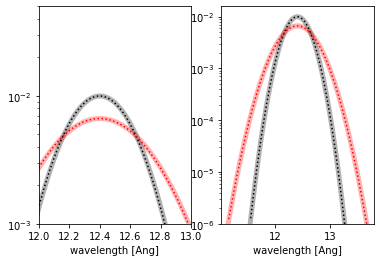

In [21]:
fig, axes = plt.subplots(ncols=2)

rmf_02 = RMF('test_lsf_gauss_meg_02.rmf')
rmf_03 = RMF('test_lsf_gauss_meg_03.rmf')

wlo02, wh02, rmfval_02 = rmf_02.rmf_ang(myenergy)
wmid02 = 0.5 * (wlo02 + wh02)

wlo03, wh03, rmfval_03 = rmf_03.rmf_ang(myenergy)
wmid03 = 0.5 * (wlo03 + wh03)



for ax in axes:
    ax.plot(wmid02, rmfval_02, 'k', lw=5, alpha=.3)
    ax.plot(wmid03, rmfval_03, 'r', lw=5, alpha=.3)
    ax.set_yscale('log')
    ax.set_xlabel('wavelength [Ang]')

    # plot line at bin midpoints, but pass x_lo, x_hi to 
    # sherpa function, because bin_width is important to
    # make integrated model (probability mass function)
    # instead of continuous model, which would 
    # have a different normalization
    ax.plot(wmid02, shmodel_02(wlo02, wh02), 'k:')
    ax.plot(wmid03, shmodel_03(wlo03, wh03), 'r:')

axes[0].set_ylim([1e-3, 5e-2])
axes[0].set_xlim([12., 13.])
axes[1].set_ylim([1e-6, None])

Gaussians in the LSFPARM file with different parameters. Thick, solid lines: RMF file, dotted lines: Sherpa model. Lines agree well, indicating that the LSFPARM files is correctly parsed.

#### Lorentz
The ICD gives the following functional form for the Lorentz (using the notation from the ICD):
$$
L(r) = \frac{L_0}{2\pi} \frac{\Gamma}{(r-r_0)^2 + \Gamma^2)}
$$
where $\Gamma$ is - according to the ICD version 0.2.1 - the half width of the function (HWHM) and $L_0$ is the "amplitude" (but see below why that is a misleading naming for that parameter). Note one missing "(" in the second fraction, which I believe to be a simply typographical error, so the definition should probably read:
$$
L(r) = \frac{L_0}{2\pi} \frac{\Gamma}{((r-r_0)^2 + \Gamma^2)}
$$
This is a somewhat surprising defintion, because it normalizes the function such that the integral is 1/2. A more common defintion in the literature (e.g. https://mathworld.wolfram.com/LorentzianFunction.html) would be to paramerize the function by the full width at half maximum (FWHM) and write the following functional form, with is normalized such the integral under der curve gives 1.
$$
L(r) = \frac{1}{2\pi} \frac{FWHM}{((r-r_0)^2 + (\frac{FWHM}{2}^2)}
$$

As shown below, the numbers in the CALDB are actually interpreted as FWHM, not HWHM.

And, just to make sure that I did not get turned around with the definition of where the 1/2 goes, here is an implementation of the Lorentz function as defined in the ICD. Evaluating that function with arbitray numbers and numerically integrating does indeed show that it is normalized to 0.5 (considering that my numerical integration goes far, but not to infinity). 

In [9]:
def lorentz_ICD_as_written(l0, gamma, r0):
    def func(x):
        return l0/(2 * np.pi) * gamma / ((x-r0)**2 + gamma**2)
    return func

x = np.arange(-100, 100, 0.01)
np.sum(lorentz_ICD_as_written(1, .345, -1)(x)) * 0.01  # 0.01 is binwidth from line above

0.4989017265206187

Next, we need to compare that to the definition of the function in Sherpa. The Sherpa docs claim the following functional form:
```
f(x) =                A * fwhm
       --------------------------------------
       2 * pi * (0.25 * fwhm^2 + (x - pos)^2)

   A = ampl / integral f(x) dx
```
Comparing that to the above, is seems that this matches the definition that I called "more common" above, so the ``integral f(x) dx`` should always be exactly 1, so it's main purpose here seems to be to confuse the reader. Let's check programatically if what's in the docs is consistent with what's acutally implemented:

In [12]:
sherpalorentz = Lorentz1D()
sherpalorentz.ampl = 1
sherpalorentz.fwhm = .345
sherpalorentz.pos = -1
np.sum(sherpalorentz(x)) * 0.01  # 0.01 is the binwidth

0.998901723250711

So, the difference between Sherpa and the functional form in the ICD is a factor of 2 in the normalization and another factor of 2 between FWHM and $\Gamma$ (the HWHM). To check that this actually matches the implementation, I now create an LSFPARM file that has only one Lorentzian in it (with normalization 1, see below for normalizations), then I run `mkgrmf` on this file and plot the resulting RMF and the shera model.

In [16]:
lonly = Table.read(os.path.join(os.environ['CALDB'], 'data', 'chandra', 'acis', 'lsfparm',
                                        'acismeg1D1999-07-22lsfparmN0005.fits'))
lonly.remove_columns(['GAUSS1_PARMS', 'GAUSS2_PARMS', 'LORENTZ2_PARMS'])
lonly['EE_FRACS'][0][:, :] = 1.
lonly['LORENTZ1_PARMS'][0][:, :, 0] = 1
lonly['LORENTZ1_PARMS'][0][:, :, 1] = .2
lonly.write('test_lsf.fits', overwrite=True)
shmodel_02 = caldb2sherpa(lonly, 0, 5, np.argmin(np.abs(lonly['LAMBDAS'] - mywave.value)))

rt.mkgrmf(outfile='test_lsf_lorentz_meg_02.rmf', wvgrid_arf='compute', order=1,
          # Use some dataset with HETG observations.
          obsfile='obs_5_tgid_4988/pha2.gz', regionfile='obs_5_tgid_4988/pha2.gz',
          srcid=1, detsubsys='ACIS-S3',
          grating_arm='MEG', ardlibparfile='ardlib.par', clobber=True)

lonly['LORENTZ1_PARMS'][0][:, :, 1] = .3
lonly.write('test_lsf.fits', overwrite=True)
shmodel_03 = caldb2sherpa(lonly, 0, 5, np.argmin(np.abs(lonly['LAMBDAS'] - mywave.value)))

rt.mkgrmf(outfile='test_lsf_lorentz_meg_03.rmf', wvgrid_arf='compute', order=1,
          # Use some dataset with HETG observations.
          obsfile='obs_5_tgid_4988/pha2.gz', regionfile='obs_5_tgid_4988/pha2.gz',
          srcid=1, detsubsys='ACIS-S3',
          grating_arm='MEG', ardlibparfile='ardlib.par', clobber=True)

Text(0.5, 1.0, 'Check width (normalized ampl)')

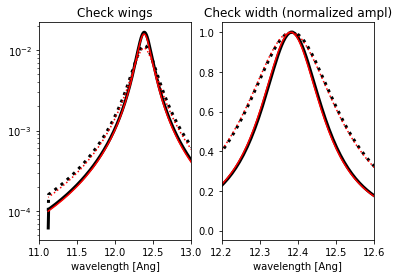

In [17]:
fig, axes = plt.subplots(ncols=2)

rmf_02 = RMF('test_lsf_lorentz_meg_02.rmf')
rmf_03 = RMF('test_lsf_lorentz_meg_03.rmf')

w_lo, w_hi, rmfval_02 = rmf_02.rmf_ang(myenergy)
w_lo, w_hi, rmfval_03 = rmf_03.rmf_ang(myenergy)
wave_mid = 0.5 * (w_hi + w_lo)

axes[0].plot(wave_mid, rmfval_02, 'k', lw=3)
axes[0].plot(wave_mid, rmfval_03, 'k:', lw=3)
axes[0].set_yscale('log')
axes[0].set_xlabel('wavelength [Ang]')

# plot line at bin midpoints, but pass x_lo, x_hi to 
# sherpa function, because bin_width is important to
# make integrated model (probability mass function)
# instead of continuous model, which would 
# have a different normalization
axes[0].plot(wave_mid, shmodel_02(w_lo, w_hi), 'r')
axes[0].plot(wave_mid, shmodel_03(w_lo, w_hi) , 'r:')

#axes[0].set_ylim([1e-3, 5e-2])
axes[0].set_xlim([11., 13.])
axes[0].set_title('Check wings')

axes[1].plot(wave_mid, rmfval_02 / rmfval_02.max(), 'k', lw=3)
axes[1].plot(wave_mid, rmfval_03 / rmfval_03.max(), 'k:', lw=3)
axes[1].set_xlabel('wavelength [Ang]')

# Normalize by hand, because I have not yet worked out the normlization
axes[1].plot(wave_mid, shmodel_02(w_lo, w_hi) / shmodel_02(w_lo, w_hi).max(), 'r')
axes[1].plot(wave_mid, shmodel_03(w_lo, w_hi) / shmodel_03(w_lo, w_hi).max(), 'r:')
axes[1].set_xlim([12.2, 12.6])
axes[1].set_title('Check width (normalized ampl)')


Lorenztians in the LSFPARM file with different parameters. Thick, solid lines: RMF file generated with `mkgrmf`, dotted lines: Sherpa model. Lines agree well, indicating that the LSFPARM files is correctly parsed.

They agree well, indicating that the numbers are correctly read and that I now understand how the ICD should be written to match what CIAO actually does. The width of the Lorentzians is set to 0.2 and 0.3, respectively, so looking at the right plot, that number is clearly the FWHM and not, as indicated in te ICD, the HWHM.

### Total and relative normalization of different components

Gauss and Lorentz functions carry an amplitide, so in theory the normalization of the total RMF, which is just the sum of the individual components, is already set by these amplitudes. However, the CALDB file also has a column `EE_FRACS`  which describes the encircled energy fraction, which seems redundant (although I can see why having that fraction tabulated in a separate column is useful from a practical persepective). Revision 0.2.1 of the ICD does not address this tension. 

So, I'm going to experiement to try out how that is inplemented in CIAO and then update the ICD to match that.

To do so, I create simple LSFPARM files where I vary the number in the `EE_FRACS` column or the amplitude of the functions and check how the RMF that's generated by `mkgrmf` changes. `mkgrmf` reads a pha file and takes certain header information from there (e.g. the grating used) as well has the regions used for extraction. Since the purpose of this experiement is to understand the file format in general, I want to avoid any dependence on the extraction width and, for experiementing, always reset numbers for all extraction widths. The pha file I use is downloaded from TGCat, but all that matter here is that it is a HETGS dataset.

In [ ]:
lsfparm = Table.read(os.path.join(os.environ['CALDB'], 'data', 'chandra', 'acis', 'lsfparm',
                                        'acismeg1D1999-07-22lsfparmN0005.fits'))
lsfparm.remove_columns(['GAUSS2_PARMS', 'LORENTZ2_PARMS'])
lsfparm['EE_FRACS'][0][:, :] = .5
# Fix positions at slightly different values so that it's eay to see if normalization is right
lsfparm['GAUSS1_PARMS'][0][:, :, 2] = 12.1
lsfparm['LORENTZ1_PARMS'][0][:, :, 2] = 12.5

lsfparm['GAUSS1_PARMS'][0][:, :, 1] = .1
lsfparm['LORENTZ1_PARMS'][0][:, :, 1] = .1

lsfparm['GAUSS1_PARMS'][0][:, :, 0] = .5
lsfparm['LORENTZ1_PARMS'][0][:, :, 0] = .5

lsfparm.write('test_lsf.fits', overwrite=True)
shmodel_eef = caldb2sherpa(lsfparm, 0, 5, np.argmin(np.abs(lsfparm['LAMBDAS'] - mywave.value)))

rt.mkgrmf(outfile='test_lsf_eef.rmf', wvgrid_arf='compute', order=1,
          # Use some dataset with HETG observations.
          obsfile='obs_5_tgid_4988/pha2.gz', regionfile='obs_5_tgid_4988/pha2.gz',
          srcid=1, detsubsys='ACIS-S3',
          grating_arm='MEG', ardlibparfile='ardlib.par', clobber=True)

lsfparm['EE_FRACS'][0][:, :] = 1.

lsfparm.write('test_lsf.fits', overwrite=True)
shmodel_5_5 = caldb2sherpa(lsfparm, 0, 5, np.argmin(np.abs(lsfparm['LAMBDAS'] - mywave.value)))

rt.mkgrmf(outfile='test_lsf_5_5.rmf', wvgrid_arf='compute', order=1,
          # Use some dataset with HETG observations.
          obsfile='obs_5_tgid_4988/pha2.gz', regionfile='obs_5_tgid_4988/pha2.gz',
          srcid=1, detsubsys='ACIS-S3',
          grating_arm='MEG', ardlibparfile='ardlib.par', clobber=True)


lsfparm['GAUSS1_PARMS'][0][:, :, 0] = .1
lsfparm['LORENTZ1_PARMS'][0][:, :, 0] = .1

lsfparm.write('test_lsf.fits', overwrite=True)
shmodel_1_1 = caldb2sherpa(lsfparm, 0, 5, np.argmin(np.abs(lsfparm['LAMBDAS'] - mywave.value)))


rt.mkgrmf(outfile='test_lsf_1_1.rmf', wvgrid_arf='compute', order=1,
          # Use some dataset with HETG observations.
          obsfile='obs_5_tgid_4988/pha2.gz', regionfile='obs_5_tgid_4988/pha2.gz',
          srcid=1, detsubsys='ACIS-S3',
          grating_arm='MEG', ardlibparfile='ardlib.par', clobber=True)


lsfparm['GAUSS1_PARMS'][0][:, :, 0] = .2
lsfparm['LORENTZ1_PARMS'][0][:, :, 0] = .1

lsfparm.write('test_lsf.fits', overwrite=True)
shmodel_2_1 = caldb2sherpa(lsfparm, 0, 5, np.argmin(np.abs(lsfparm['LAMBDAS'] - mywave.value)))

rt.mkgrmf(outfile='test_lsf_2_1.rmf', wvgrid_arf='compute', order=1,
          # Use some dataset with HETG observations.
          obsfile='obs_5_tgid_4988/pha2.gz', regionfile='obs_5_tgid_4988/pha2.gz',
          srcid=1, detsubsys='ACIS-S3',
          grating_arm='MEG', ardlibparfile='ardlib.par', clobber=True)

In [ ]:
rmf_eef = RMF('test_lsf_eef.rmf')
rmf_5_5 = RMF('test_lsf_5_5.rmf')
rmf_1_1 = RMF('test_lsf_1_1.rmf')
rmf_2_1 = RMF('test_lsf_2_1.rmf')

wl_eef, wh_eef, rmfval_eef = rmf_eef.rmf_ang(myenergy)
wave_eef = 0.5 * (wl_eef + wh_eef)
wl_5_5, wh_5_5, rmfval_5_5 = rmf_5_5.rmf_ang(myenergy)
wave_5_5 = 0.5 * (wl_5_5 + wh_5_5)
wl_1_1, wh_1_1, rmfval_1_1 = rmf_1_1.rmf_ang(myenergy)
wave_1_1 = 0.5 * (wl_1_1 + wh_1_1)
wl_2_1, wh_2_1, rmfval_2_1 = rmf_2_1.rmf_ang(myenergy)
wave_2_1 = 0.5 * (wl_2_1 + wh_2_1)

In [ ]:
fig, ax = plt.subplots()

ax.plot(wave_eef, rmfval_eef, 'g', lw=7, alpha=.3, label='gauss: .1, lorentz=.1 (and EEF=.5)')
ax.plot(wave_eef, shmodel_eef(wl_eef, wh_eef), 'g:')

ax.plot(wave_5_5, rmfval_5_5, 'b', lw=7, alpha=.3, label='gauss: .5, lorentz=.5')
ax.plot(wave_5_5, shmodel_5_5(wl_5_5, wh_5_5), 'b:')

ax.plot(wave_1_1, rmfval_1_1, 'k', lw=3, alpha=.3, label='gauss: .1, lorentz=.1')
ax.plot(wave_1_1, shmodel_1_1(wl_1_1, wh_1_1), 'k:')

ax.plot(wave_2_1, rmfval_2_1, 'r', lw=3, alpha=.3, label='gauss: .2, lorentz=.1')
ax.plot(wave_2_1, shmodel_2_1(wl_2_1, wh_2_1), 'r:')

ax.set_xlabel('wavelength [Ang]')
ax.legend()
#ax.set_yscale('log')
#axes[0].set_ylim([1e-3, 5e-2])
ax.set_xlim([11.8, 13.9])
#axes[1].set_ylim([1e-7, 1])

The RMF is normalized such that the sum over all channels sums up to the number in the EE_FRACS column, i.e. only the EE_FRACS column affects the overall normalization (the green and blue lines differ by a factor if 2 in the EE_FRACS values). In other words, it is a probability mass function associated with a specific set of discrete channels.

As we see in this figure, changing the amplitude of the function definition in the LSFPARM file, but keeping the overall EE_FRAC constant leads `mkgrmf` to generate the same RMF (blue and black lines). The amplitude only matters relatively if more than one function is present in the LSFPARM file. The overall amplitude is given solely by the EE_FRAC column. The blue/black line and the red line have the same EE_FRACS but in the red line the ratio of the amplitudes of the two components is different, resulting in the different shape of the function.

In [ ]:
np.sum(rmfval_1_1), np.sum(shmodel_1_1(wl_1_1, wh_1_1))

The number above are the RMF summed over all channels, and the Sherpa model summed over all channels. The summ of the RMF is the number set in the EE_FRAC column (here 1) to numerical precision. The Sherpa model number is lower, because the normalization of the sherpa model is set, such that the integral from $-\infty$ to $+\infty$ is 1, but in the RMF channels below a certain value are omitted. The difference is about 0.3% and not relevant for what follows; it can be resolved by using a bigger RMF with more channels.